In [2]:
!pip install pandas scikit-learn xgboost matplotlib seaborn streamlit


Defaulting to user installation because normal site-packages is not writeable
  Using cached xgboost-3.0.2-py3-none-win_amd64.whl.metadata (2.1 kB)
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/150.0 MB ? eta -:--:--


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from xgboost import XGBClassifier


In [5]:
df = pd.read_csv(r"C:\Users\hr157\Downloads\credit card\creditcard.csv")
df.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


Dataset shape: (284807, 31)
Class
0    284315
1       492
Name: count, dtype: int64


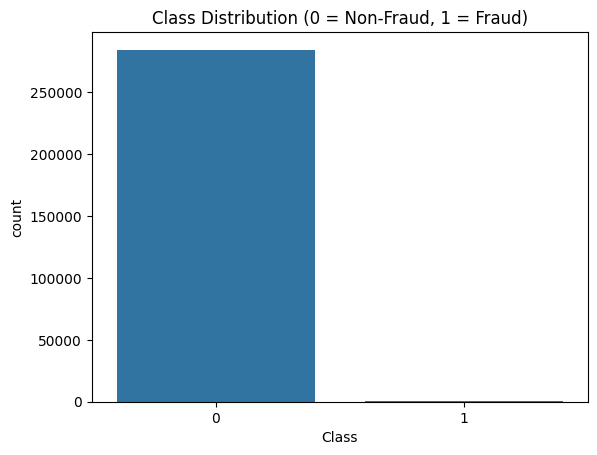

In [6]:
print("Dataset shape:", df.shape)
print(df['Class'].value_counts())

sns.countplot(data=df, x='Class')
plt.title("Class Distribution (0 = Non-Fraud, 1 = Fraud)")
plt.show()


In [7]:
df['NormalizedAmount'] = StandardScaler().fit_transform(df[['Amount']])
df.drop(['Time', 'Amount'], axis=1, inplace=True)


In [8]:
X = df.drop('Class', axis=1)
y = df['Class']

# Isolation Forest
iforest = IsolationForest(contamination=0.0017, random_state=42)
y_pred_if = iforest.fit_predict(X)
y_pred_if = [1 if x == -1 else 0 for x in y_pred_if]

# Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.0017)
y_pred_lof = lof.fit_predict(X)
y_pred_lof = [1 if x == -1 else 0 for x in y_pred_lof]

print("Isolation Forest Confusion Matrix:\n", confusion_matrix(y, y_pred_if))
print("LOF Confusion Matrix:\n", confusion_matrix(y, y_pred_lof))


Isolation Forest Confusion Matrix:
 [[283969    346]
 [   353    139]]
LOF Confusion Matrix:
 [[283835    480]
 [   492      0]]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [10]:
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


C:\Users\hr157\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [10:30:12] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
 [[56853    11]
 [   20    78]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.88      0.80      0.83        98

    accuracy                           1.00     56962
   macro avg       0.94      0.90      0.92     56962
weighted avg       1.00      1.00      1.00     56962



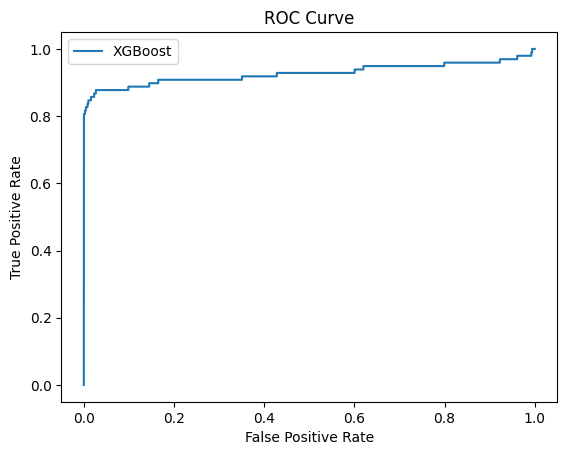

ROC AUC Score: 0.9268201143006443


In [11]:
y_probs = xgb_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_probs)

plt.figure()
plt.plot(fpr, tpr, label='XGBoost')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

print("ROC AUC Score:", roc_auc_score(y_test, y_probs))


In [12]:
import joblib
joblib.dump(xgb_model, 'xgb_model.pkl')


['xgb_model.pkl']